In [1]:
# Playgroud Series - Binary Classification of Insurance Cross Selling
  # https://www.kaggle.com/competitions/playground-series-s4e7
  # Your Goal: predict which customers respond positively to an automobile insurance offer.
  # Metric: Submissions are evaluated using area under the ROC curve.

# Improvements (to do)

In [1]:
#DONE v1 and v2:
# use more data (used 100k on train).  -> DT was practically not improved, even with 1.5M rows on test. Saw an post showing there are many repeated rows on dataset.
    # There are no duplicated rows on test data (11M). Removind 1 feature per time, all of them have many duplicates (downsampling). There was no gain of doing that. (https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517167)
# Plot ROC_AUC curve to compare moodel

#DONE V3:
#Probabilistic approach

#DONE V4:
# tested LogisticRegressionCV and  LogisticRegression + GridSearchCV (fine tuning). -> RF is still superior.

#DONE V5:
# CatBoost wuthout default params

#DONE V6
# Balance CatBoost -> did not imporve
# CatBoost + GridSearchCV -> did not improve
# CatBoost + GridSearchCV of [AutoML Grand Prix] 1st Place Solution (https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution) -> did not improve

#TODO V7
# Data Prep/Feature Engeering and Cat Boost of [AutoML Grand Prix] 1st Place Solution (https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution)
    # Did not run with 11Mi train rows locally (few mommory). Tried w/ 100k train and full test (needed to submit).
    # User iterations=1000 instead of 5000, and task_type= 'CPU', cause 'GPU' -> Demands NVidea graphics cards w/ CUDA
    # Undestood StratifiedKFold w/ CatBoost cross validation
    # Kaggle public score: 0.884 (best by far!)

#######################
# Model Tuning: RandomizedSearchCV.

#IMPROVE EDA
# Follow Kaggle notebooks

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import polars as pl

pd.set_option('display.float_format', lambda x: '%.3f' % x) #pandas decimal places
pd.set_option('max_colwidth', 100) #num of cols to be shown
np.set_printoptions(suppress=True, precision=6)#numpy decimal placese


from sklearn.model_selection       import train_test_split, GridSearchCV, StratifiedKFold#, cross_val_score
from sklearn.preprocessing         import MinMaxScaler #OneHotEncoder  
from sklearn.metrics               import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree                  import DecisionTreeClassifier, plot_tree
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import LogisticRegressionCV, LogisticRegression

from catboost                      import CatBoostClassifier, Pool #Numpy downgrade needed: pip install numpy==1.26.4 (from mar/24)



# #import sweetviz as sv
# from yellowbrick.features import ParallelCoordinates

# Load Data

In [92]:
## load data
#train = pl.read_csv('..\\data\\kaggle\\train.csv')

# Specify the path to your CSV file and read a random sample of the dataset
train = pl.read_csv('..\\data\\kaggle\\train.csv').sample(n=500000)
test = pl.read_csv('..\\data\\kaggle\\test.csv') #.sample(n=70000) needs to be full, cause I neet to submit all the rows!
test = test.with_columns(pl.lit(0).cast(pl.Int64).alias('Response'))

In [93]:
train[:2]

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
i64,str,i64,i64,f64,i64,str,str,f64,f64,i64,i64
5528186,"""Female""",70,1,38.0,0,"""1-2 Year""","""Yes""",28341.0,124.0,288,1
10297802,"""Male""",65,1,31.0,1,"""1-2 Year""","""No""",2630.0,124.0,131,0


In [94]:
test[:2]

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
i64,str,i64,i64,f64,i64,str,str,f64,f64,i64,i64
11504798,"""Female""",20,1,47.0,0,"""< 1 Year""","""No""",2630.0,160.0,228,0
11504799,"""Male""",47,1,28.0,0,"""1-2 Year""","""Yes""",37483.0,124.0,123,0


In [82]:
## prepare data
df = pl.concat([train, test])

df = df.with_columns([
    pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
    pl.col('Region_Code').cast(int),
    pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
    pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
    pl.col('Annual_Premium').cast(int),
    pl.col('Policy_Sales_Channel').cast(int)
])

df = df.with_columns([
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Annual_Premium'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Age'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Age'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Damage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Damage'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vintage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vintage')
])

train = df[:train.shape[0]].to_pandas()
test = df[train.shape[0]:].to_pandas()

In [ ]:
#Why just interactions with Previously_Insured variable?
    #https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516475#2901376
#-> We ran all combinations of interactions on a smaller subset (500K rows) and chose the Top-3/4 based on feature importance. 
    #Any interaction with Previously_Insured seemed to work the best

# It was on top of feature importance, as seen on other topic:
    #https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516860

#Feature Engeneering with high Feature Importances:
    #https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517112
    #Previously_Insured_Vehicle_Damage
    #Vehicle_Age_Damage

In [83]:
# PANDAS EQUIVALENT:

# Concatenate train and test DataFrames
# df_pd = pd.concat([train_pd, test_pd], ignore_index=True)

# # Convert specific columns
# df_pd['Gender'] = df_pd['Gender'].replace({'Male': 0, 'Female': 1}).astype('int32')
# df_pd['Region_Code'] = df_pd['Region_Code'].astype(int)
# df_pd['Vehicle_Age'] = df_pd['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('int32')
# df_pd['Vehicle_Damage'] = df_pd['Vehicle_Damage'].replace({'No': 0, 'Yes': 1}).astype('int32')
# df_pd['Annual_Premium'] = df_pd['Annual_Premium'].astype(int)
# df_pd['Policy_Sales_Channel'] = df_pd['Policy_Sales_Channel'].astype(int)

# # Factorize and create new columns  -> pd.factorize() is a function in Pandas that is used to encode categorical (or object) data as integer values.
# df_pd['Previously_Insured_Annual_Premium'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Annual_Premium'].astype(str))[0]
# df_pd['Previously_Insured_Vehicle_Age'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Vehicle_Age'].astype(str))[0]
# df_pd['Previously_Insured_Vehicle_Damage'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Vehicle_Damage'].astype(str))[0]
# df_pd['Previously_Insured_Vintage'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Vintage'].astype(str))[0]

# # Split back into train and test DataFrames
# train_pd = df_pd.iloc[:len(train_pd)]
# test_pd = df_pd.iloc[len(train_pd):]

# # Reset index if needed
# train_pd.reset_index(drop=True, inplace=True)
# test_pd.reset_index(drop=True, inplace=True)

# # Optionally, print or inspect the resulting train_pd and test_pd DataFrames
# print(train_pd.head())
# print(test_pd.head())


In [84]:
train[:2]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage
0,1167552,0,25,1,17,1,0,0,37685,152,235,0,0,0,0,0
1,6255103,1,41,1,8,0,1,1,34824,124,132,1,1,1,1,1


In [85]:
test[:2]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage
0,17858327,0,31,1,8,1,0,0,36551,152,246,0,87,0,0,90
1,15485695,0,27,1,10,1,0,0,30798,152,242,0,88,0,0,91


In [86]:
#variations of each column
print(f"- Distinct values:\n{train.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{train.apply( lambda x: x.unique() ) } " )

- Distinct values:
id                                   100
Gender                                 2
Age                                   38
Driving_License                        1
Region_Code                           33
Previously_Insured                     2
Vehicle_Age                            3
Vehicle_Damage                         2
Annual_Premium                        86
Policy_Sales_Channel                  13
Vintage                               82
Response                               2
Previously_Insured_Annual_Premium     87
Previously_Insured_Vehicle_Age         5
Previously_Insured_Vehicle_Damage      3
Previously_Insured_Vintage            90
dtype: int64 

- Variations:
id                                   [1167552, 6255103, 9416081, 1304135, 3516439, 7909097, 4033434, 9723731, 7070276, 2899910, 95813...
Gender                                                                                                                            [0, 1]
Age                   

# ML

In [87]:
#StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
    #  Some classification problems can exhibit a large imbalance in the distribution of the target classes.
    # In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

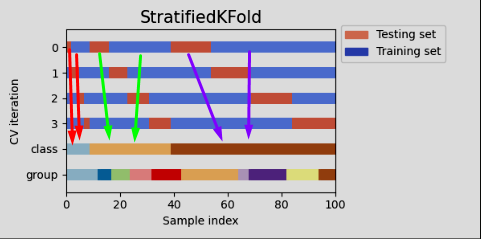

In [24]:
## train model

#store for each folder
aucs = [] 
preds = []

#A StratifiedKFold object is created for 3-fold cross-validation. This method ensures that the class distribution is approximately the same in each fold as in the whole dataset.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#A loop is initiated to iterate over each fold generated by StratifiedKFold.
    #train_idx contains the indexes of the folder, and it's used to build x_train, 
for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Response'])):
    print(f'### Fold {fold+1} Training ###')

    #For each fold, the training and validation sets are extracted from the train dataframe. The X_test dataset is also prepared using the same features as in the training data.

    #Create a new DataFrame X_train containing the rows specified by train_idx and all columns from train except for the columns 'id' and 'Response'.
    X_train = train.loc[train_idx, [c for c in train.columns if c not in ['id', 'Response']]]
    y_train = train.loc[train_idx, 'Response']
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, 'Response']
    X_test = test[X_train.columns]

    #The data is converted into CatBoost Pool objects, which is the required format for training and evaluation in CatBoost.
    X_train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=X_valid.columns.values)
    X_test_pool = Pool(X_test, cat_features=X_test.columns.values)

    #Initialize and Train the CatBoost Model:
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.05,
        iterations=1000, #5000 original
        depth=9,
        random_strength=0,
        l2_leaf_reg=0.5,
        task_type= 'CPU', #'GPU' -> Demands NVidea graphics cards w/ CUDA
        random_seed=42,
        verbose=False
    )
    #A CatBoostClassifier model is initialized with specific parameters. The model is then trained on the training data and validated on the validation data. Early stopping is used to prevent overfitting.
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000, early_stopping_rounds=200)
    
    #Predictions for the validation set are made, and the AUC score is calculated. Predictions for the test set are stored, to be submitted.
    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)

    #The AUC score for the current fold is printed.
    print(f'Fold {fold+1} AUC: {auc:.5f}\n')

#Calculate and Print Overall (mean) AUC:
print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###
0:	test: 0.8659257	best: 0.8659257 (0)	total: 663ms	remaining: 11m 2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8821454377
bestIteration = 295

Shrink model to first 296 iterations.
Fold 1 AUC: 0.88215

### Fold 2 Training ###
0:	test: 0.8657121	best: 0.8657121 (0)	total: 593ms	remaining: 9m 51s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8824506249
bestIteration = 444

Shrink model to first 445 iterations.
Fold 2 AUC: 0.88245

### Fold 3 Training ###
0:	test: 0.8644237	best: 0.8644237 (0)	total: 526ms	remaining: 8m 45s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8820728529
bestIteration = 365

Shrink model to first 366 iterations.
Fold 3 AUC: 0.88207


Overall AUC: 0.88222 +/- 0.00016


In [ ]:
# Did not compare to all other because would need to run all transformations ans models, and than this. 

In [ ]:
# Submission 7:    100k rows train, iterations=200,  n_splits=5  -->   Overall AUC: 0.87713 +/- 0.00288
# Submission 7.1   500k rows train, iterations=500,  n_splits=3  -->   Overall AUC: 0.88222 +/- 0.00016
# Submission 7.2   500k rows train, iterations=1000,  n_splits=3  -->   Overall AUC: 0.88222 +/- 0.00016 (did not improve AUC)

In [26]:
preds[:1]

[array([0.006725, 0.404007, 0.234319, ..., 0.000843, 0.468008, 0.000043])]

# Kaggle Submission

In [23]:
## create submission
submission = test[['id']]
submission['Response'] = np.mean(preds, axis=0)

submission.to_csv('..\\data\\v7\\submission_v7.1.csv', index=False)
submission

C:\Users\norton\AppData\Local\Temp\ipykernel_17272\17073533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Response'] = np.mean(preds, axis=0)


,id,Response
0,11504798,0.006
1,11504799,0.443
2,11504800,0.245
3,11504801,0.000
4,11504802,0.109
...,...,...
7669861,19174659,0.168
7669862,19174660,0.000
7669863,19174661,0.001
7669864,19174662,0.451


In [96]:
submission.to_parquet('..\\data\\v7\\submission_v7.1.parquet', engine='pyarrow')